In [1]:
import os

import geopandas
import intake
import ipywidgets
import matplotlib.pyplot as plt
import pandas
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.pipeline

cat = intake.open_catalog("../catalogs/*.yml")

In [2]:
# Load PCTS extract
pcts = cat.pcts2.read()

In [3]:
parcel_to_tract = pandas.read_parquet(
    "s3://city-planning-entitlements/data/crosswalk_parcels_tracts.parquet"
)

In [4]:
# ACS data for income, race, commute, tenure
census = pandas.read_parquet(
    "s3://city-planning-entitlements/data/final/census_analysis_table.parquet"
)

In [5]:
# Census tracts
tracts = cat.census_tracts.read()
tracts = tracts.assign(
    density=tracts.HD01_VD01.astype(int)/(tracts.Shape_STAr/5280./5280.),
    population=tracts.HD01_VD01,
)

In [6]:
# The requested entitlements are in the suffixes of the PCTS case number.
# A given case can have an arbitrary number of entitlement suffixes, so
# we need to parse it into its component parts.
# We can use a regex for that:

from utils import GENERAL_PCTS_RE
cols = pcts.CASE_NBR.str.extract(GENERAL_PCTS_RE)

In [7]:
all_suffixes = cols[3].str.strip("-").str.split("-", expand=True)

In [8]:
suffix_counts = (all_suffixes
    .apply(lambda col: col.value_counts(), axis=0)
    .sum(axis=1)
    .astype(int)
    .sort_values(ascending=False)
)

In [9]:
# Associate each PCTS entitlement case with a census tract:
pcts = pcts.merge(
    parcel_to_tract[["GEOID", "AIN"]],
    how="left",
    on="AIN",
)

In [10]:
pcts_suffixes = pandas.concat((pcts, all_suffixes), axis=1)

In [11]:
# Drop child cases
pcts_suffixes = pcts_suffixes[pcts_suffixes.PARNT_CASE_ID.isna()]

In [12]:
# Each case can have multiple suffixes. However, it is useful
# to be able to refer to a single suffix column when performing
# aggregations and computing statistics.
# Here we melt the suffix columns into a single column.
# This has the effect of creating multiple rows for cases
# that have multiple entitlements being requested.
pcts_suffixes = pcts_suffixes.melt(
    id_vars=pcts.columns,
    var_name="nothing",
    value_name="suffix"
).dropna(subset=["suffix"]).drop(columns=["nothing"])

In [13]:
# Drop some cases which are region-wide, touching thousands of parcels,
# or should otherwise be ignored.
pcts_suffixes = pcts_suffixes[
    ~pcts_suffixes.suffix.isin(("CPU", "CA", "SP", "SN", "ICO", "HPOZ", "HD", "FH"))
]

In [14]:
big_cases = pcts_suffixes.CASE_ID.value_counts()
big_cases = big_cases[big_cases > 10]
pcts_suffixes = pcts_suffixes[~pcts_suffixes.CASE_ID.isin(big_cases.index)]

In [15]:
# Our first pass at analyzing entitlements is to count the number
# of cases for each census tract, to see which kinds of entitlements
# are being applied for in which types of census tract:
entitlement_counts = (pcts_suffixes
    .groupby(["GEOID", "suffix", "CASE_YR_NBR"])
    .size()
    .to_frame("n")
).reset_index(level=1).reset_index(level=1).rename(columns={"CASE_YR_NBR": "year"})
entitlement_counts = entitlement_counts.assign(
    year=entitlement_counts.year.astype("Int64")
)

In [16]:
entitlement_counts

,year,suffix,n
GEOID,,,
06037101110,2012,CE,2
06037101110,2014,CRA,1
06037101110,2013,CWC,1
06037101110,2012,GPA,2
06037101110,2013,SPP,1
...,...,...,...
06037980028,2020,EIR,2
06037980028,2014,MND,1
06037980028,2018,MND,1


In [17]:
start_year = 2010
end_year = 2019

year_condition = entitlement_counts.year > start_year

entitlement_subset = entitlement_counts[year_condition]
most_common_entitlements = entitlement_subset[["suffix", "n"]].groupby("suffix").sum()
include_entitlements = most_common_entitlements.sort_values("n", ascending=False).head(30).index
include_entitlements

Index(['CE', 'GPA', 'EIR', 'CRA', 'CUB', 'DI', 'ND', 'MND', 'MA', 'CWC', 'SPP',
       'ZV', 'MSC', 'SPR', 'CU', 'VSO', 'ZC', 'ZAA', 'CEX', 'MEL', 'TOC',
       'DRB', 'OVR', 'EXT', 'CWNC', 'PMEX', 'CPIOC', 'CUW', '1A', 'DB'],
      dtype='object', name='suffix')

In [18]:
entitlements = entitlement_subset.pivot_table(
    index=entitlement_subset.index,
    values="n",
    columns="suffix",
    aggfunc="sum",
).filter(
    include_entitlements
).fillna(0).astype("int64")

In [19]:
entitlements

suffix,CE,GPA,EIR,CRA,CUB,DI,ND,MND,MA,CWC,...,TOC,DRB,OVR,EXT,CWNC,PMEX,CPIOC,CUW,1A,DB
GEOID,,,,,,,,,,,,,,,,,,,,,
06037101110,2,2,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
06037101122,1,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
06037101210,8,3,4,0,3,1,0,1,0,2,...,0,0,0,1,0,0,0,0,0,0
06037101220,0,0,1,2,1,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
06037101300,8,1,4,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
06037297602,10,2,2,0,4,1,0,2,0,0,...,0,1,0,0,0,0,2,0,0,0
06037980010,2,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
06037980014,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
joined = pandas.merge(
    census.dropna().set_index("GEOID"),
    entitlements,
    how="left",
    left_index=True,
    right_index=True,
).fillna(0).reset_index().merge(
    tracts[["GEOID10", "geometry"]],
    how="left",
    left_on="GEOID",
    right_on="GEOID10",
).drop(columns="GEOID10").set_index("GEOID").dropna()
joined

,non_car_workers,workers_total,pct_non_car_workers,zero_veh_workers,pct_zero_veh_workers,pop_renter,pop_total,pct_pop_renter,pop_whitenonhisp,pct_whitenonhisp,...,DRB,OVR,EXT,CWNC,PMEX,CPIOC,CUW,1A,DB,geometry
GEOID,,,,,,,,,,,,,,,,,,,,,
06037101110,46,1927,0.023871,0,0.000000,2199,4219,0.521214,2516,0.583217,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((6471651.068 1918306.964, 64719..."
06037101122,11,1907,0.005768,8,0.004195,577,3234,0.178417,2755,0.850571,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"MULTIPOLYGON (((6477840.844 1917081.399, 64778..."
06037101210,171,2770,0.061733,114,0.041155,5247,5987,0.876399,2991,0.494217,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((6475267.737 1915630.020, 64752..."
06037101220,54,1513,0.035691,54,0.035691,2110,3497,0.603374,1694,0.484415,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((6477611.571 1915577.225, 64775..."
06037101300,86,2041,0.042136,10,0.004900,353,4250,0.083059,3503,0.815220,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((6481507.143 1914335.333, 64815..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
06037930200,18,167,0.107784,0,0.000000,94,386,0.243523,271,0.646778,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((6434869.547 1942437.807, 64350..."
06037980015,14,289,0.048443,9,0.031142,525,525,1.000000,84,0.151079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((6467779.957 1740632.011, 64685..."
06037980019,0,76,0.000000,0,0.000000,25,151,0.165563,125,0.827815,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"MULTIPOLYGON (((6388919.695 1848109.430, 63889..."


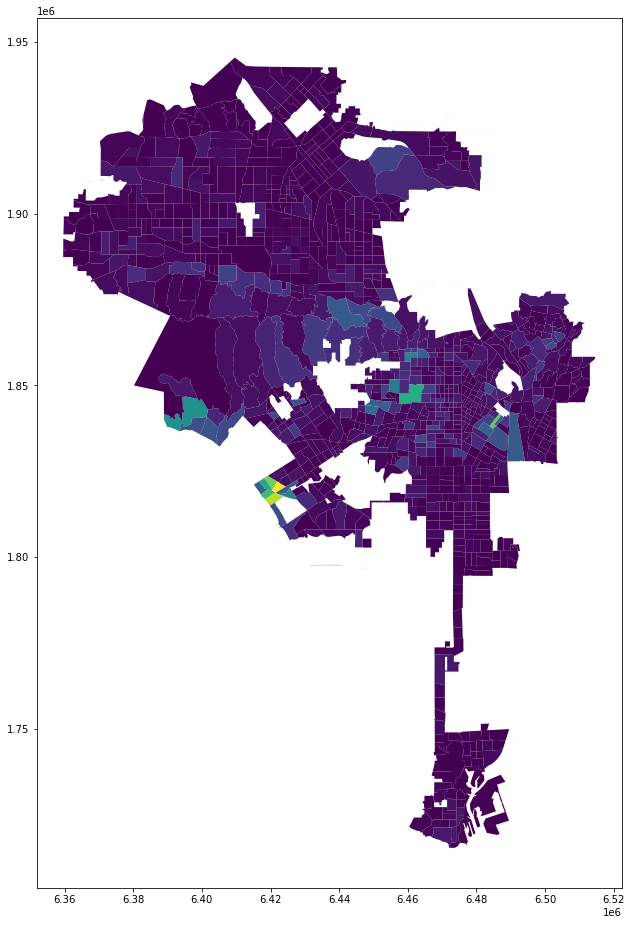

In [21]:
column = "CE"
geopandas.GeoDataFrame(
    joined.assign(**{column: joined[column]}), geometry="geometry"
).plot(figsize=(16,16), column=column)

In [22]:
joined.columns

Index(['non_car_workers', 'workers_total', 'pct_non_car_workers',
       'zero_veh_workers', 'pct_zero_veh_workers', 'pop_renter', 'pop_total',
       'pct_pop_renter', 'pop_whitenonhisp', 'pct_whitenonhisp', 'medhhincome',
       'total_lt10', 'total_r10to14', 'total_r15to19', 'total_r20to24',
       'total_r25to29', 'total_r30to34', 'total_r35to39', 'total_r40to44',
       'total_r45to49', 'total_r50to59', 'total_r60to74', 'total_r75to99',
       'total_r100to124', 'total_r125to149', 'total_r150to199', 'total_gt200',
       'total_total', 'density', 'CE', 'GPA', 'EIR', 'CRA', 'CUB', 'DI', 'ND',
       'MND', 'MA', 'CWC', 'SPP', 'ZV', 'MSC', 'SPR', 'CU', 'VSO', 'ZC', 'ZAA',
       'CEX', 'MEL', 'TOC', 'DRB', 'OVR', 'EXT', 'CWNC', 'PMEX', 'CPIOC',
       'CUW', '1A', 'DB', 'geometry'],
      dtype='object')

In [23]:
cols=["medhhincome", "pct_pop_renter", "pct_zero_veh_workers", "density"]

In [24]:
model = sklearn.pipeline.Pipeline([
    ("scaler", sklearn.preprocessing.StandardScaler(with_mean=True)),
    ("regressor", sklearn.linear_model.PoissonRegressor(fit_intercept=True, tol=1.e-6))
])

In [25]:
from sklearn.utils import resample
import numpy as np
np.random.seed(1)

def fit_model(target): 
    def get_coefs(model):
        #return np.concatenate(([model["regressor"].intercept_], model["regressor"].coef_))
        return model["regressor"].coef_

        
    samples = np.array([
        get_coefs(model.fit(*resample(
            joined[cols],
            (joined[target]/joined.pop_total).replace([np.nan, np.inf], 0.0),
        )))
        for i in range(100)
    ])
    return samples

Fitting model for CE
Fitting model for GPA
Fitting model for EIR
Fitting model for CRA
Fitting model for CUB
Fitting model for DI
Fitting model for ND
Fitting model for MND
Fitting model for MA
Fitting model for CWC
Fitting model for SPP
Fitting model for ZV
Fitting model for MSC
Fitting model for SPR
Fitting model for CU
Fitting model for VSO
Fitting model for ZC
Fitting model for ZAA
Fitting model for CEX
Fitting model for MEL
Fitting model for TOC
Fitting model for DRB
Fitting model for OVR
Fitting model for EXT
Fitting model for CWNC
Fitting model for PMEX
Fitting model for CPIOC
Fitting model for CUW
Fitting model for 1A
Fitting model for DB


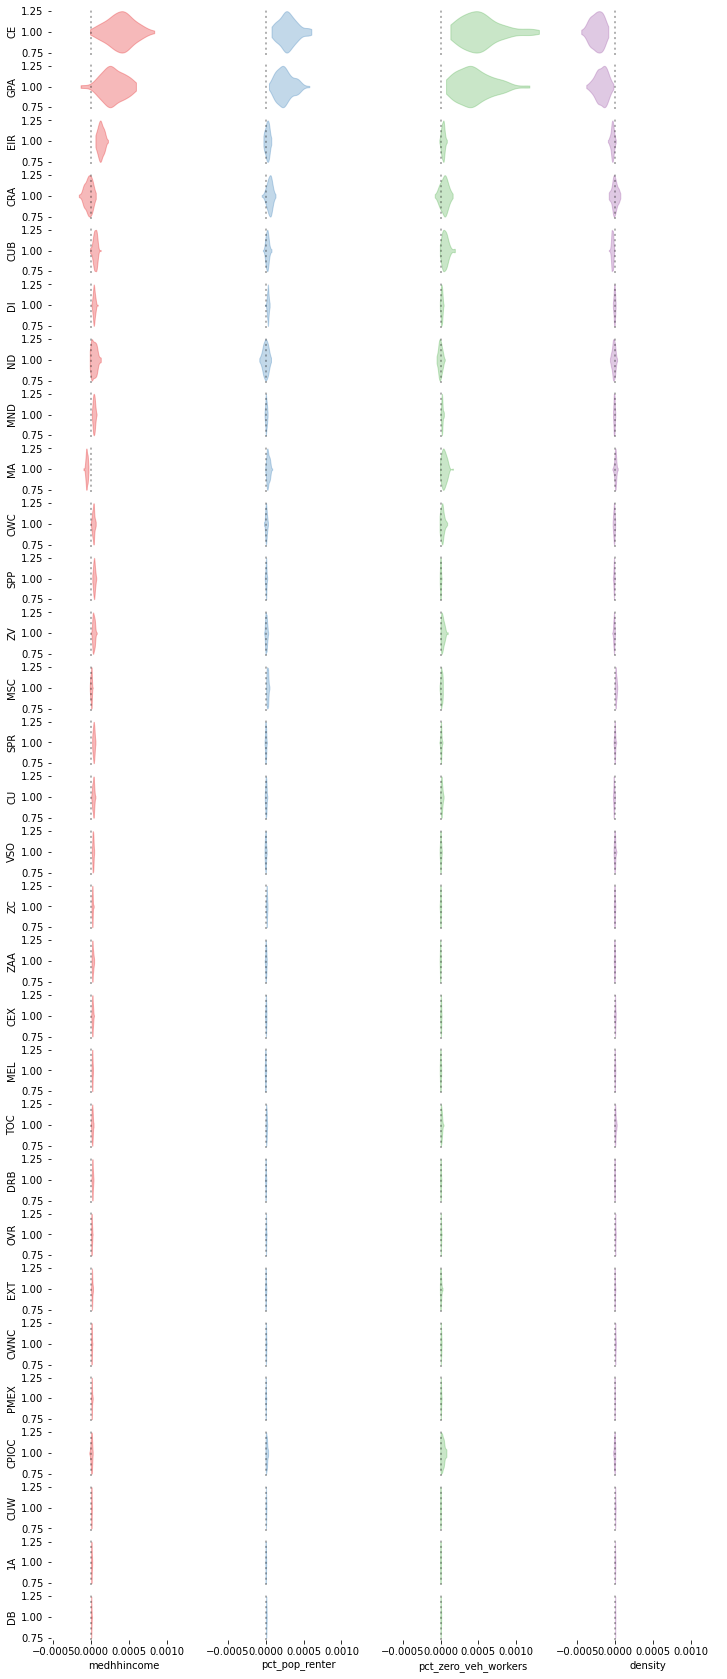

In [26]:
inc = include_entitlements

fig, axes = plt.subplots(
    len(inc),
    len(cols),
    sharex=True,
    sharey=True,
    figsize=(12, 1*len(inc)),
)

colors = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3", "#ff7f00"]

for i, ent in enumerate(inc):
    print(f"Fitting model for {ent}")
    samples = fit_model(ent)
    for j, var in enumerate(cols):
        ax = axes[i, j]
        ax.axvline(0, linewidth=2, alpha=0.3, color="k", linestyle="dotted")
        for spine in ax.spines:
            ax.spines[spine].set_visible(False)
        if j == 0:
            ax.set_ylabel(ent)
        else:
            ax.tick_params(which="both", right=False, left=False)
            
        if i == len(inc)-1:
            ax.set_xlabel(var)
        else:
            ax.tick_params(which="both", bottom=False)

        parts = ax.violinplot(samples[:, j], vert=False, showextrema=False)
        for pc in parts['bodies']:
            pc.set_color(colors[j])

fig.show()

In [27]:
fig.savefig("entitlements.png")

In [28]:
def plot_model(ent):
    model.fit(joined[cols], (joined[ent]/joined.pop_total).replace([np.nan, np.inf], 0.0))
    fig, axes = plt.subplots(1, len(cols), figsize=(12, 3))
    for i, var in enumerate(cols):
        ax = axes[i]
        ax.scatter(joined[var], joined[ent])
        #ax.scatter(joined[var], model.predict(joined[cols]))
        ax.set_xlabel(var)
        if i == 0:
            ax.set_ylabel("Count")
    plt.close(fig) # prevent double plotting
    return fig

In [29]:
def plot_map(ent):
    model.fit(joined[cols], (joined[ent]/joined.pop_total).replace([np.nan, np.inf], 0.0))
    gdf = geopandas.GeoDataFrame(joined.assign(predict=model.predict(joined[cols])))
    vmax = gdf[ent].max()
    vmin = gdf[ent].min()
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    gdf.plot(column=ent, cmap="magma", ax=ax[0])
    gdf.plot(column="predict", cmap="magma", ax=ax[1])
    ax[0].axis("off")
    ax[1].axis("off")
    ax[0].set_title(f"Number of {ent}")
    ax[1].set_title(f"Predicted number of {ent}")
    plt.close(fig)
    return fig

In [30]:
output = ipywidgets.Output()
dropdown = ipywidgets.Dropdown(options=inc)
def on_selection(*args):
    with output:
        output.clear_output(wait=True)
        display(plot_map(dropdown.value), plot_model(dropdown.value))
dropdown.observe(on_selection, names=["value"])

on_selection()
display(dropdown, output)

Dropdown(options=('CE', 'GPA', 'EIR', 'CRA', 'CUB', 'DI', 'ND', 'MND', 'MA', 'CWC', 'SPP', 'ZV', 'MSC', 'SPR',…

Output()